In [83]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [84]:
df = pd.read_csv("cleaned_df.csv")

In [85]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1233 entries, 0 to 1232
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Timestamp                  1233 non-null   object
 1   Age                        1233 non-null   int64 
 2   Gender                     1233 non-null   object
 3   Country                    1233 non-null   object
 4   state                      1233 non-null   object
 5   self_employed              1233 non-null   object
 6   family_history             1233 non-null   object
 7   treatment                  1233 non-null   object
 8   work_interfere             1233 non-null   object
 9   no_employees               1233 non-null   object
 10  remote_work                1233 non-null   object
 11  tech_company               1233 non-null   object
 12  benefits                   1233 non-null   object
 13  care_options               1233 non-null   object
 14  wellness

In [86]:
df.isnull().sum()

,0
Timestamp,0
Age,0
Gender,0
Country,0
state,0
self_employed,0
family_history,0
treatment,0
work_interfere,0
no_employees,0


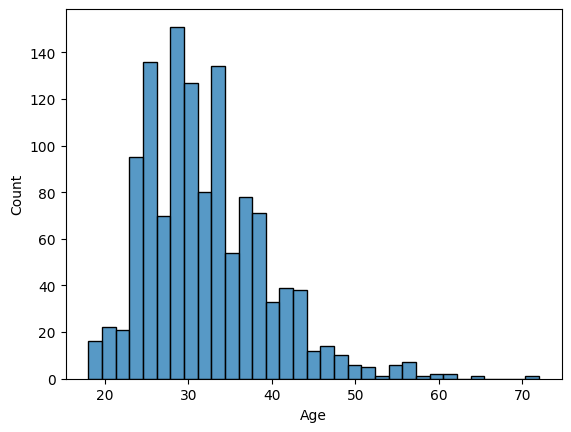

In [87]:
colors = sns.color_palette('pastel')
sns.histplot(df['Age'])
plt.show()

<Axes: ylabel='Age'>

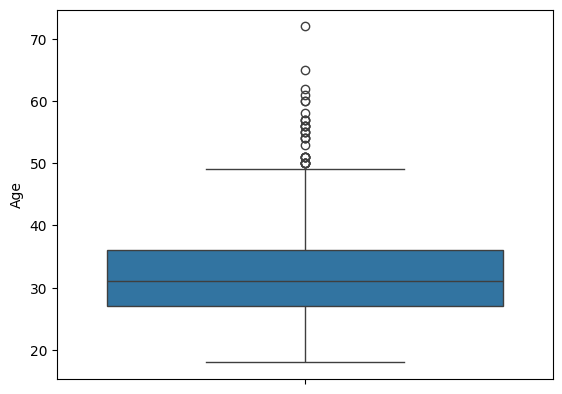

In [88]:
sns.boxplot(df['Age'])

In [89]:
df['Standardized_gender'].value_counts().index

Index(['male', 'female', 'other'], dtype='object', name='Standardized_gender')

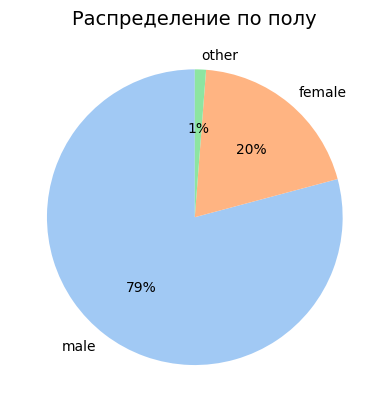

In [90]:
colors = sns.color_palette('pastel')

values = df['Standardized_gender'].value_counts().values
labels = df['Standardized_gender'].value_counts().index

plt.pie(values,
        labels=labels,
        autopct='%1.0f%%',
        startangle=90,
        colors=colors)

plt.title('Распределение по полу', fontsize=14)
plt.show()


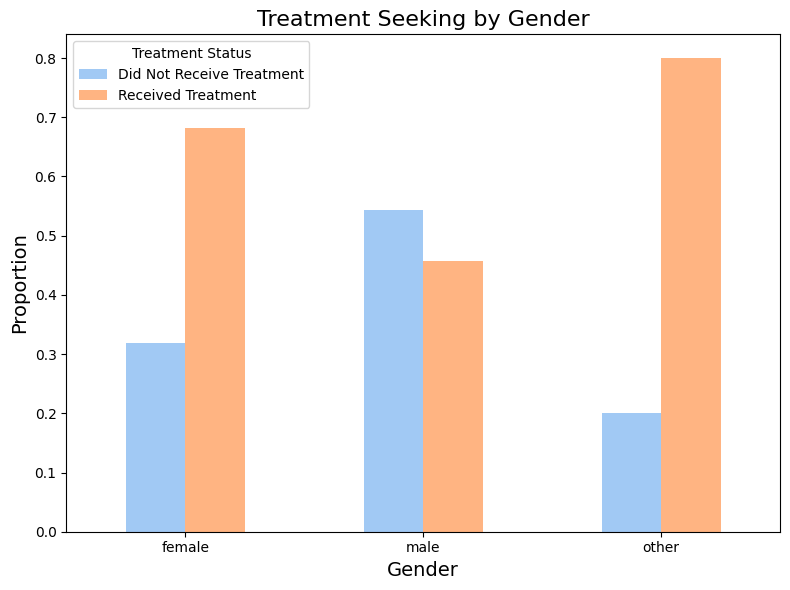

In [91]:
treatment_labels = ['Did Not Receive Treatment', 'Received Treatment']


treatment_by_gender = df.groupby('Standardized_gender')['treatment'].value_counts(normalize=True).unstack().fillna(0)
treatment_by_gender.plot(kind='bar', stacked=False, color=sns.color_palette('pastel'), figsize=(8, 6))

plt.title('Treatment Seeking by Gender', fontsize=16)
plt.xlabel('Gender', fontsize=14)
plt.ylabel('Proportion', fontsize=14)
plt.xticks(rotation=0)

plt.legend(title='Treatment Status', labels=treatment_labels)
plt.tight_layout()
plt.show()

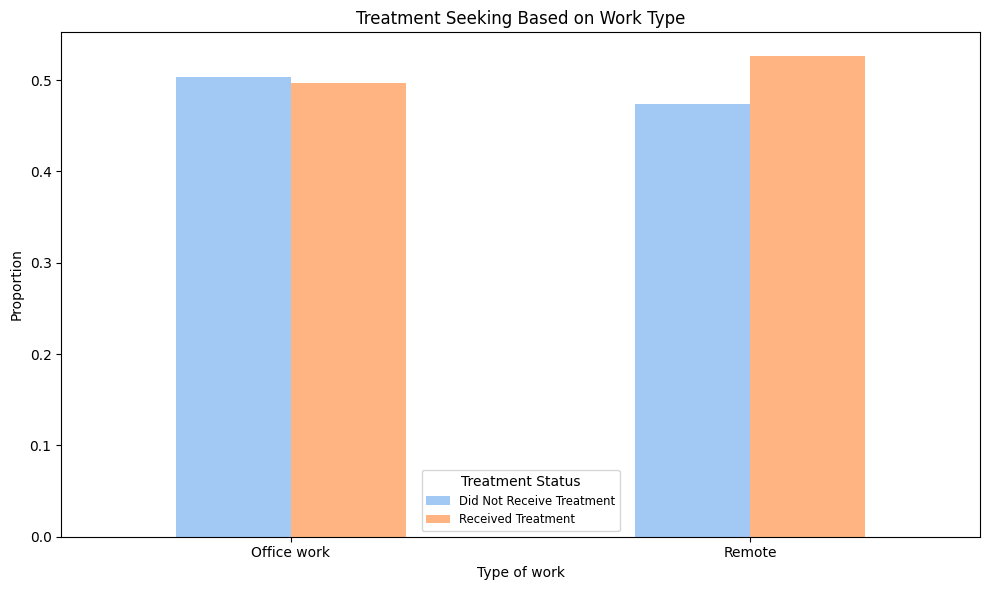

In [92]:
treatment_by_type_work = df.groupby('remote_work')['treatment'].value_counts(normalize=True).unstack()
treatment_by_type_work.plot(kind='bar', stacked=False, color=sns.color_palette('pastel'), figsize=(10, 6))

plt.title('Treatment Seeking Based on Work Type')
plt.xlabel('Type of work')
plt.ylabel('Proportion')
plt.xticks(rotation=0)

plt.gca().set_xticklabels(['Office work', 'Remote'])

plt.legend(title='Treatment Status', labels=treatment_labels, fontsize='small')
plt.tight_layout()
plt.show()

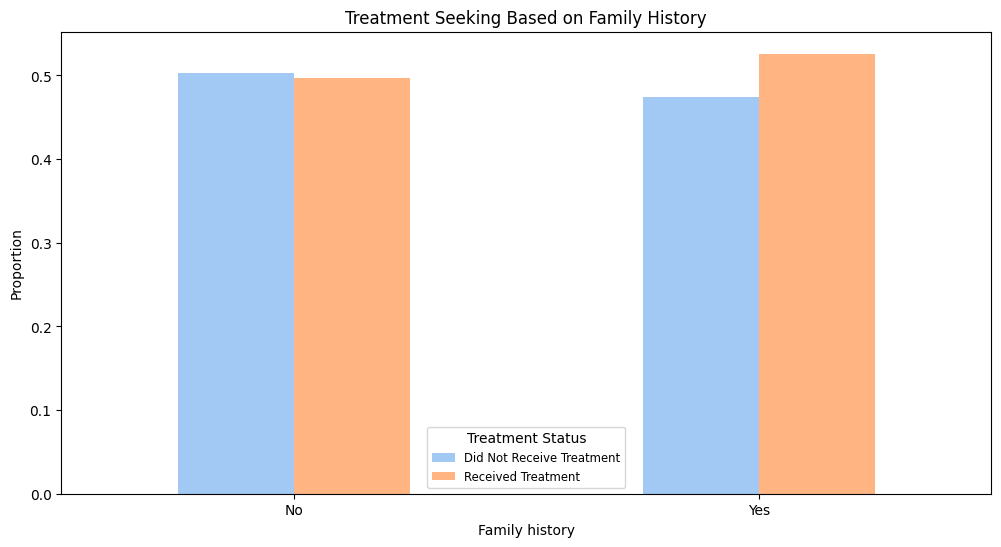

In [93]:
treatment_by_family_hist = df.groupby('family_history')['treatment'].value_counts(normalize=True).unstack()
treatment_by_type_work.plot(kind='bar', stacked=False, color=sns.color_palette('pastel'), figsize=(12, 6))

plt.title('Treatment Seeking Based on Family History')
plt.xlabel('Family history')
plt.ylabel('Proportion')
plt.xticks(rotation=0)
plt.legend(title='Treatment Status', labels=treatment_labels, fontsize='small')

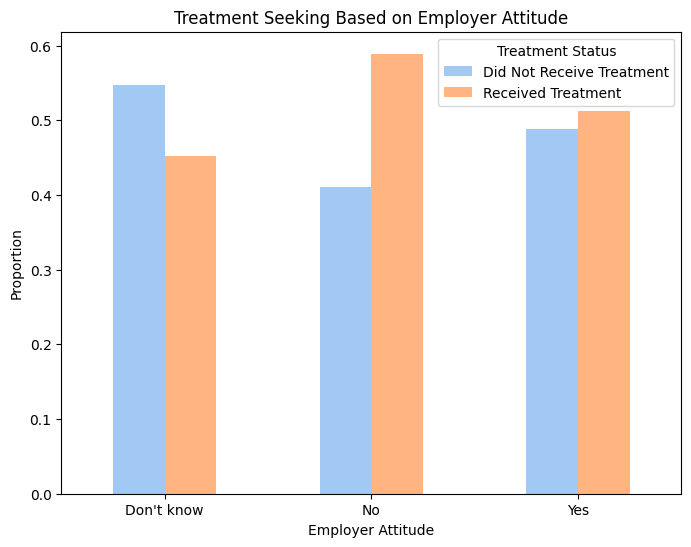

In [94]:
treatment_by_employer_attitude = df.groupby('mental_vs_physical')['treatment'].value_counts(normalize=True).unstack()
treatment_by_employer_attitude.plot(kind='bar', stacked=False, color=sns.color_palette('pastel'), figsize=(8, 6))

plt.title('Treatment Seeking Based on Employer Attitude')
plt.xlabel('Employer Attitude')
plt.ylabel('Proportion')
plt.xticks(rotation=0)
plt.legend(title='Treatment Status', labels=treatment_labels)
plt.show()